In [2]:
from qiskit.circuit.library import UnitaryGate
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from collections import Counter  
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt  
#from controlled_gates import append_conditional_gates

## Initialization

We start the system with $n$ qubits and $n$ ancillas, each for each qubit. The ancillas will allow us to perform irreversible operations to model the failure of the dependencies in the network.

(1) In the first step, we make a rotation on the qubits based on the risk the qubits have for failing from the attacks. We want to rotate the qubits such that, if their net probability of failing from the round of attacks is $r_i$, then

\begin{equation*}
    |s_i (0)\rangle  \to \sqrt{1-r_i}| 0 \rangle + \sqrt{r_i}| 1 \rangle 
\end{equation*}

We will use a rotation on the $y$-axis, so we will find the angle $\theta_{ri}$ that corresponds to the appropriate operation. The rotation is given by the matrix

\begin{equation*}
    R_y(\theta_{ri}) =
\begin{bmatrix}
\cos\left(\frac{\theta_{ri}}{2}\right) & - \sin\left(\frac{\theta_{ri}}{2}\right) \\
\sin\left(\frac{\theta_{ri}}{2}\right) & \cos\left(\frac{\theta_{ri}}{2}\right)
\end{bmatrix}
\end{equation*}

Then, we solve the system of linear equations

\begin{equation*}
    R_y(\theta_{ri}) \begin{bmatrix} 1 \\  0 \end{bmatrix} = \begin{bmatrix}
\cos\left(\frac{\theta_{ri}}{2}\right) & - \sin\left(\frac{\theta_{ri}}{2}\right) \\
\sin\left(\frac{\theta_{ri}}{2}\right) & \cos\left(\frac{\theta_{ri}}{2}\right)
\end{bmatrix} \begin{bmatrix} 1 \\  0 \end{bmatrix}= \begin{bmatrix} \sqrt{1-r_i} \\ \sqrt{r_i} \end{bmatrix}
\end{equation*}



Taking the second equation,

\begin{align*}
    \sin\left( \frac{\theta{ri}}{2} \right) &= \sqrt{r_i} \\
    \theta_{ri} &= 2 \arcsin( \sqrt{r_i})
\end{align*}

In the second step, we make a particular entanglement through a CNOT gate. For each qubit $s_i$ and its corresponding ancilla $u_i$, we make a CNOT with control over the $s_i$ and the target as $u_i$. This will produce that the states,

\begin{align*}
    |0,0\rangle \to |0,0 \rangle \\
    |1,0\rangle \to |1,1 \rangle    
\end{align*}

In particular, after the rotation, we will have the state $|s_i\rangle \otimes |u_i\rangle =  \sqrt{1-r_i}|0,0 \rangle - \sqrt{r_i}|1,0 \rangle $, which will be transformed to 

\begin{align*}
    \sqrt{1-r_i}|0,0 \rangle - \sqrt{r_i}|1,0 \rangle  \to \sqrt{1-r_i}|0,0 \rangle - \sqrt{r_i}|1,1\rangle
\end{align*}

(3) In the third step, we collapse the original qubits doing a measurement. This will cause the superposition to break, and the ancillas will also be determined to a particular state. This is reflected via $|u_i \rangle = |0\rangle, |1\rangle$. This step is important because we will use the ancillas to make controlled rotations based on the adjacency matrix since we cannot perform controlled rotations with qubits using the same qubits for the targets and the controls (it is an irreversible operation). However, the ancillas are guaranteed to have the same state as their original qubits $|s_i \rangle$.

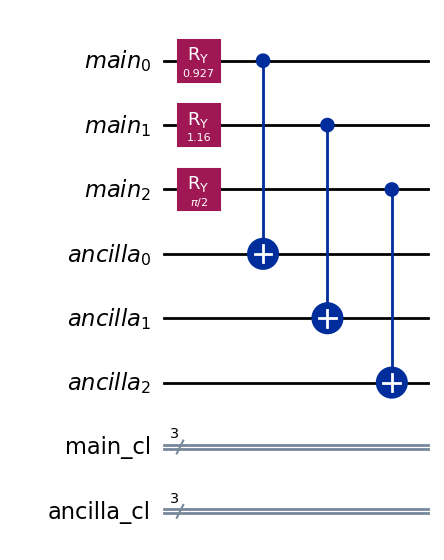

In [7]:
risk_vector = np.array([0.2,0.3,0.5])
# each risk_vector[i] is the value r_i

num_qubits = len(risk_vector)
num_ancillas = num_qubits

# qubits and ancillas
main_qubits = QuantumRegister(num_qubits,'main')
ancilla_qubits = QuantumRegister(num_ancillas,'ancilla')

# classical registers for measuring and collapsing the qubits
main_clbits = ClassicalRegister(num_qubits, 'main_cl')
ancilla_clbits = ClassicalRegister(num_ancillas, 'ancilla_cl')

# Initialize the quantum circuit with qubits, ancillas, and classical registers
qc = QuantumCircuit(main_qubits,ancilla_qubits, main_clbits,ancilla_clbits)

# Step 1: Rotating the original qubits
for index in range(num_qubits):

    theta_ri = 2*np.arcsin(np.sqrt(risk_vector[index]))
    qc.ry(theta_ri,main_qubits[index])

# Step 2: Entangling the qubits

for index in range(num_qubits):
    qc.cx(main_qubits[index],ancilla_qubits[index])

qc.draw("mpl")

To work on: 

    (1) Implementing controlled rotations based on the adjacency matrix. 

    (2) Making sure the circuit is optimized for the IBM Quantum platform.

    (3) Adding error handling and validation checks.